In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [16]:
# CONSTANTS
tubL, tubW, tubH = 1.25, 0.60, 0.35 # meters
molWaterInM3 = 55493.9 # mol / meter^3
humanCP = 62.97 # J / mol K

In [21]:
# VARIABLES
countL, countW, countH = 40, 20, 10#5, 5, 5 #50, 25, 25 # dimensionless
bathStartingTemp = 37 # deg celsius
dt = 0.1 # seconds

In [22]:
def getWaterDiffusivity(temp):
    lmda = 0.561 + 0.002 * temp + 0.00000962 * (temp ** 2)
    cp = 75.98 - 0.061 * temp + 0.002 * (temp ** 2) - 0.00001755 * (temp ** 3)
    rho = 999.86 + 0.058 * temp - 0.008 * (temp ** 2) + 0.0000397 * (temp ** 3)
    return lmda / (cp * rho)

def getSubsectionVolumeMols():
    return molWaterInM3 * (tubL/countL) * (tubW/countW) * (tubH/countH)

def getNewTempArray():
    return bathStartingTemp*np.ones((countL+1, countW+1, countH+1))

def getCellLagrangian(tub, l, w, h):
    distL, distW, distH = tubL/countL, tubW/countW, tubH/countH
    # print(tub[l-1][w][h], tub[l][w][h], tub[l+1][w][h])
    ddL = 0 if l == 0 or l == countL else float(tub[l+1][w][h] + tub[l-1][w][h] - 2*tub[l][w][h])/(distL ** 2)
    ddW = 0 if w == 0 or w == countW else float(tub[l][w+1][h] + tub[l][w-1][h] - 2*tub[l][w][h])/(distL ** 2)
    ddH = 0 if h == 0 or h == countH else float(tub[l][w][h+1] + tub[l][w][h-1] - 2*tub[l][w][h])/(distL ** 2)
    return (ddL, ddW, ddH)
    
def cellStep(tub):
    diffusionL, diffusionW, diffusionH = np.copy(tub), np.copy(tub), np.copy(tub)
    for l in range(0, countL+1):
        for w in range(0, countW+1):
            for h in range(0, countH+1):
                wd = getWaterDiffusivity(tub[l][w][h])
                dd = getCellLagrangian(tub, l, w, h)
                mm = getSubsectionVolumeMols()
                diffusionL[l][w][h], diffusionW[l][w][h], diffusionH[l][w][h] = dt*mm*wd*dd[0], dt*mm*wd*dd[1], dt*mm*wd*dd[2]
    tmp = np.add(diffusionL, diffusionW)
    tmp = np.add(tmp, diffusionH)
    #print(tmp)
    return np.add(tub, tmp)
    #print(np.add(tub, tmp))

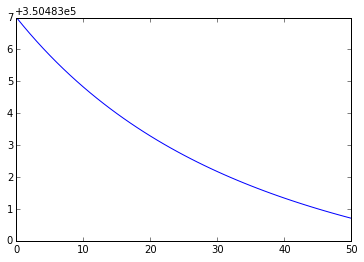

In [28]:
arr = getNewTempArray();
arr[3][3][3] = 100

aList = [np.sum(arr)]

for i in range(0, 50):
    arr = cellStep(arr)
    #print("STEP " + str(i))
    aList.append(np.sum(arr))
plt.plot(aList)
#print(aList)

In [25]:
print(getSubsectionVolumeMols())

1.82089359375
